# **Sentiment Analysis**
In this notebook, we will use the embeddings we trained earlier to solve the task of sentiment analysis upon the IMDB reviews dataset. 

## **Define notebook constants**

In [1]:
base_url = '../'
dictionary_size = 25000
review_max_len = 300
embedding_dim = 64

## **Import essential libraries**

In [2]:
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

## **Load trained embeddings**

In [3]:
embedding_mat = joblib.load(base_url + 'Embedding/embeddings.pkl')
word_to_index = joblib.load(base_url + 'Embedding/word_to_index_map.pkl')
index_to_word = joblib.load(base_url + 'Embedding/index_to_word_map.pkl')

In [4]:
# End of sentence token
embedding_mat = np.vstack((embedding_mat, 0 * np.ones((1, embedding_dim))))
# Unknown word token
embedding_mat = np.vstack((embedding_mat, 1 * np.ones((1, embedding_dim))))
# Null word token
embedding_mat = np.vstack((embedding_mat, -1 * np.ones((1, embedding_dim))))

## **Load dataset**

In [5]:
df = pd.read_csv(base_url + 'Sentiment Analysis/IMDB Dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
df.iloc[50, 0]

'Return to the 36th Chamber is one of those classic Kung-Fu movies which Shaw produces back in the 70s and 80s, whose genre is equivalent to the spaghetti westerns of Hollywood, and the protagonist Gordon Liu, the counterpart to the western\'s Clint Eastwood. Digitally remastered and a new print made for the Fantastic Film Fest, this is "Presented in Shaw Scope", just like the good old days.<br /><br />This film is a simple story of good versus evil, told in 3 acts, which more or less sums up the narrative of martial arts films in that era.<br /><br />Act One sets up the premise. Workers in a dye-mill of a small village are unhappy with their lot, having their wages cut by 20% by incoming manchu gangsters. They can\'t do much about their exploitation because none of them are martial arts skilled to take on the gangsters, and their boss. At first they had a minor success in getting Liu to impersonate a highly skilled Shaolin monk (one of the best comedy sequences), but their rouse got e

## **Clean dataset reviews**

In [8]:
allowed_chars = []
allowed_chars.extend([chr(c) for c in range(ord('a'), ord('z') + 1, 1)])
allowed_chars.extend([chr(c) for c in range(ord('0'), ord('9') + 1, 1)])
allowed_chars.extend([' ', '.'])

In [9]:
def clean_review(review):
    verbose = ''
    review = review.lower()
    for c in review:
        if c in allowed_chars:
            verbose += c
        else:
            verbose += ' '
    cleaned = ''
    for c in verbose:
        if c == ' ':
            if cleaned[-1:] != ' ':
                cleaned += c
        elif c == '.':
            if cleaned[-1:] != '.':
                cleaned += ' ' + c
        else:
            cleaned+= c
    return cleaned.replace(' br ', '')

In [10]:
df["review"] = df["review"].apply(clean_review)

In [11]:
df.iloc[50, 0]

'return to the 36th chamber is one of those classic kung fu movies which shaw produces back in the 70s and 80s whose genre is equivalent to the spaghetti westerns of hollywood and the protagonist gordon liu the counterpart to the western s clint eastwood . digitally remastered and a new print made for the fantastic film fest this is presented in shaw scope just like the good old days .br this film is a simple story of good versus evil told in 3 acts which more or less sums up the narrative of martial arts films in that era .br act one sets up the premise . workers in a dye mill of a small village are unhappy with their lot having their wages cut by 20 by incoming manchu gangsters . they can t do much about their exploitation because none of them are martial arts skilled to take on the gangsters and their boss . at first they had a minor success in getting liu to impersonate a highly skilled shaolin monk one of the best comedy sequences but their rouse got exposed when they pushed the l

## **Exploratory Data Analysis: Observing the trends in the lengths of different reviews**

In [12]:
lengths = []
for i in range(df.shape[0]):
    words = list(filter(lambda x: len(x) > 0, map(str.strip, df.iloc[i, 0].split(' '))))
    lengths.append(len(words))

In [13]:
max_len = max(lengths)
print(max_len)

2624


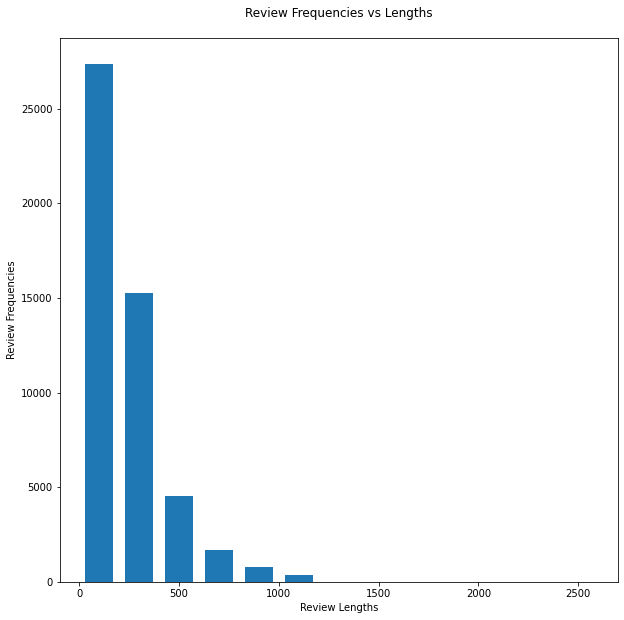

In [14]:
bins = [i for i in range(0, max_len, 200)]
plt.hist(lengths, bins, rwidth=0.7)
plt.xlabel('Review Lengths')
plt.ylabel('Review Frequencies')
plt.title('Review Frequencies vs Lengths\n')
plt.show()

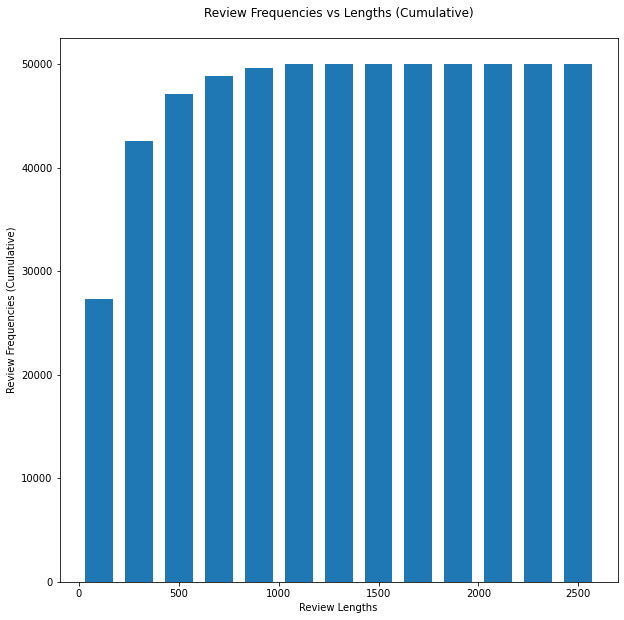

In [15]:
plt.hist(lengths, bins, rwidth=0.7, cumulative=True)
plt.xlabel('Review Lengths')
plt.ylabel('Review Frequencies (Cumulative)')
plt.title('Review Frequencies vs Lengths (Cumulative)\n')
plt.show()

## **Convert reviews to index sequences**

In [16]:
def convert_to_ind_seq(words):
    unknown_count, word_count = 0, 0
    indices = [dictionary_size + 2 for i in range(review_max_len)]
    i = 0 if (len(words) <= review_max_len) else (len(words) - review_max_len)
    j = 0 if (len(words) >= review_max_len) else (review_max_len - len(words))
    while i < len(words):
        word = words[i]
        if word in word_to_index:
            indices[j] = word_to_index[word]
        else:
            if word[0] == '.':
                indices[j] = dictionary_size
            else:
                indices[j] = dictionary_size + 1
                unknown_count += 1
        i += 1
        j += 1
        word_count += 1
    return indices, unknown_count, word_count

In [17]:
X, Y = [], []
unknown_count, word_count = 0, 0
for i in range(df.shape[0]):
    Y.append((0 if df.iloc[i, 1] == 'negative' else 1, ))
    words = list(filter(lambda x: len(x) > 0, map(str.strip, df.iloc[i, 0].split(' '))))
    indices, unk_w, tot_w = convert_to_ind_seq(words)
    unknown_count += unk_w
    word_count += tot_w
    X.append(indices)

In [19]:
print('Unknown words percentage =', unknown_count / word_count * 100)

Unknown words percentage = 8.691008631845374


In [18]:
X = np.array(X, dtype=np.uint32)
Y = np.array(Y, dtype=np.uint8)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## **Deep LSTM model**

In [21]:
def get_deep_LSTM_model():
    inputs = tf.keras.layers.Input(shape=(review_max_len,))
    embeddings = tf.keras.layers.Embedding(dictionary_size + 3, embedding_dim, weights=[embedding_mat], 
                    trainable=True)(inputs)
    lstm_layer_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
    lstm_layer_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_layer_1)
    dense_1 = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_layer_2)
    model = tf.keras.models.Model(inputs=[inputs], outputs=[dense_1])
    return model

In [22]:
deep_LSTM_model = get_deep_LSTM_model()

In [23]:
deep_LSTM_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 64)           1600192   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          98816     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,830,721
Trainable params: 1,830,721
Non-trainable params: 0
_________________________________________________________________


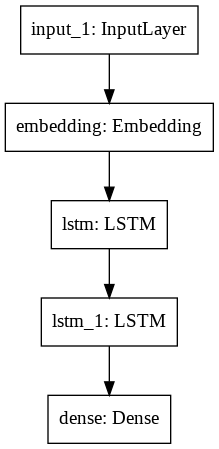

In [24]:
tf.keras.utils.plot_model(deep_LSTM_model)

### **Fit data to deep LSTM model**

In [ ]:
deep_LSTM_model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), 
    metrics=['accuracy']
)

In [ ]:
deep_LSTM_model.fit(X_train, Y_train, batch_size=256, epochs=15, validation_data=(X_test, Y_test))

Epoch 1/15
157/157 [==============================] - 14s 88ms/step - loss: 0.6919 - accuracy: 0.5252 - val_loss: 0.6879 - val_accuracy: 0.5703
Epoch 2/15
157/157 [==============================] - 13s 85ms/step - loss: 0.6789 - accuracy: 0.5883 - val_loss: 0.6656 - val_accuracy: 0.6043
Epoch 3/15
157/157 [==============================] - 13s 85ms/step - loss: 0.6222 - accuracy: 0.6534 - val_loss: 0.5975 - val_accuracy: 0.6862
Epoch 4/15
157/157 [==============================] - 13s 85ms/step - loss: 0.5752 - accuracy: 0.7037 - val_loss: 0.5666 - val_accuracy: 0.7117
Epoch 5/15
157/157 [==============================] - 13s 86ms/step - loss: 0.5480 - accuracy: 0.7270 - val_loss: 0.5478 - val_accuracy: 0.7260
Epoch 6/15
157/157 [==============================] - 13s 85ms/step - loss: 0.5275 - accuracy: 0.7413 - val_loss: 0.5339 - val_accuracy: 0.7372
Epoch 7/15
157/157 [==============================] - 13s 85ms/step - loss: 0.5099 - accuracy: 0.7541 - val_loss: 0.5240 - val_accuracy:

### **Evaluate deep LSTM model**

In [ ]:
predictions = np.around(deep_LSTM_model.predict(X_test))

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, predictions, average='weighted')
print('Precision =', round(precision, 4))
print('Recall =', round(recall, 4))
print('F1 Score =', round(f1, 4))

Precision = 0.8011
Recall = 0.8005
F1 Score = 0.8004


### **Make predictions**

In [126]:
def predict(review, model):
    review = clean_review(review)
    words = list(filter(lambda x: len(x) > 0, map(str.strip, review.split(' '))))
    inp = np.array(convert_to_ind_seq(words)[0]).reshape((1, review_max_len))
    out = model.predict(inp)[0][0]
    print(out)
    return 'Positive Review' if out >= 0.5 else 'Negative Review'

In [ ]:
predict('It was not a good movie.', deep_LSTM_model)

## **Attention Model**

In [25]:
attention_length = 100
n_bi_rnn = 64
n_attention_lstm = 128

In [26]:
def get_attention_model():
    repeat = tf.keras.layers.RepeatVector(review_max_len)
    concatenate = tf.keras.layers.Concatenate(axis=-1)
    dense1 = tf.keras.layers.Dense(32, activation='tanh')
    dense2 = tf.keras.layers.Dense(1, activation='relu')
    activate = tf.keras.layers.Activation('softmax')
    dot = tf.keras.layers.Dot(axes=1)
    output = tf.keras.layers.Dense(1, activation='sigmoid')

    def get_context(bi_rnn, prev_activation):
        prev_activation = repeat(prev_activation)
        inputs = concatenate([bi_rnn, prev_activation])
        intermediates = dense1(inputs)
        energies = dense2(intermediates)
        alphas = activate(energies)
        return dot([alphas, bi_rnn])

    a0 = tf.keras.layers.Input(shape=(n_attention_lstm,))
    c0 = tf.keras.layers.Input(shape=(n_attention_lstm,))
    inputs = tf.keras.layers.Input(shape=(review_max_len,))
    embeddings = tf.keras.layers.Embedding(dictionary_size + 3, embedding_dim, 
                    weights=[embedding_mat], trainable=True)(inputs)
    bi_rnn1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_bi_rnn, 
                    return_sequences=True))(embeddings)
    bi_rnn2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=n_bi_rnn, 
                    return_sequences=True))(bi_rnn1)
    a = a0
    c = c0
    attention_LSTM = tf.keras.layers.LSTM(units=n_attention_lstm, return_state=True)
    outputs = []
    for i in range(attention_length):
        context = get_context(bi_rnn2, a)
        a, _, c = attention_LSTM(inputs=context, initial_state=[a, c])
        if i == attention_length - 1:
            outputs.append(output(a))
    
    model = tf.keras.models.Model(inputs=[inputs, a0, c0], outputs=outputs)
    return model

In [27]:
attention_model = get_attention_model()

In [28]:
attention_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 64)      1600192     input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 300, 128)     66048       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
_______________________________________________________________________________________

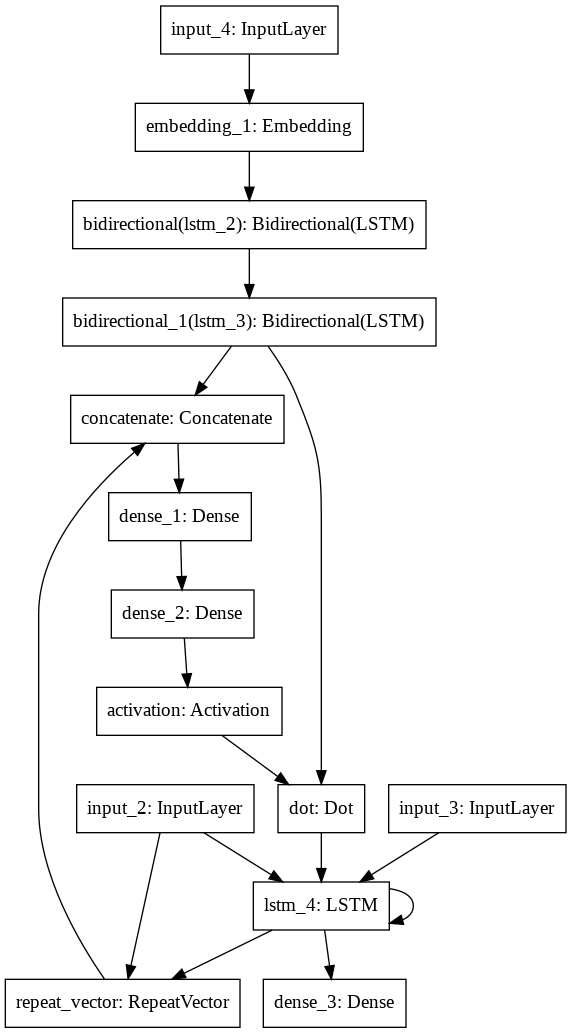

In [30]:
tf.keras.utils.plot_model(attention_model, to_file=base_url + 'model.png')

### **Fit data to attention model**

In [31]:
attention_model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003), 
    metrics=['accuracy']
)

In [32]:
a0_train = np.zeros((X_train.shape[0], n_attention_lstm))
c0_train = np.zeros((X_train.shape[0], n_attention_lstm))
a0_test = np.zeros((X_test.shape[0], n_attention_lstm))
c0_test = np.zeros((X_test.shape[0], n_attention_lstm))

In [36]:
attention_model.fit([X_train, a0_train, c0_train], Y_train, batch_size=256, epochs=3, 
        validation_data=([X_test, a0_test, c0_test], Y_test))

Epoch 1/3
157/157 [==============================] - 277s 2s/step - loss: 0.3573 - accuracy: 0.8441 - val_loss: 0.3971 - val_accuracy: 0.8240
Epoch 2/3
157/157 [==============================] - 277s 2s/step - loss: 0.3545 - accuracy: 0.8458 - val_loss: 0.3926 - val_accuracy: 0.8262
Epoch 3/3
157/157 [==============================] - 277s 2s/step - loss: 0.3445 - accuracy: 0.8518 - val_loss: 0.3911 - val_accuracy: 0.8266


### **Evaluate attention model**

In [37]:
predictions = np.around(attention_model.predict([X_test, a0_test, c0_test]))

In [38]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, predictions, average='weighted')
print('Precision =', round(precision, 4))
print('Recall =', round(recall, 4))
print('F1 Score =', round(f1, 4))

Precision = 0.8275
Recall = 0.8266
F1 Score = 0.8265


### **Make predictions**

In [39]:
def predict(review, model):
    review = clean_review(review)
    words = list(filter(lambda x: len(x) > 0, map(str.strip, review.split(' '))))
    inp = np.array(convert_to_ind_seq(words)[0]).reshape((1, review_max_len))
    out = model.predict([inp, np.zeros((1, n_attention_lstm)), np.zeros((1, n_attention_lstm))])[0][0]
    return 'Positive Review' if out >= 0.5 else 'Negative Review'

In [ ]:
predict('It was not a good movie.', attention_model)